In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import seaborn as sns

# CAISO 5-Minute Data EDA

## Loading in the Data

We're also making some small adjustments here, such as ordering the data in chronologic order, and converting data to Pacific time for simplicity.

In [197]:
data = pd.read_csv("../data-files/CAISO_data.csv")
data = data.drop("Unnamed: 0", axis=1)
data = data.sort_values('timestamp')
data['timestamp'] = pd.to_datetime(data['timestamp']).dt.tz_convert('US/Pacific') # Convert times to pacific
data['timestamp'] = data['timestamp'].dt.tz_localize(None) # Drop timezone info to prevent weird bugs
data.head()

,timestamp,freq,market,ba_name,load_MW
171,2015-01-01 00:00:00,5m,RT5M,CAISO,23041.0
55,2015-01-01 00:05:00,5m,RT5M,CAISO,22937.0
77,2015-01-01 00:10:00,5m,RT5M,CAISO,22824.0
132,2015-01-01 00:15:00,5m,RT5M,CAISO,22707.0
111,2015-01-01 00:20:00,5m,RT5M,CAISO,22596.0


## Minor feature engineering

We're doing some small feature engineering to make visualizing particular trends easier. Some engineering we're doing:
1. The `minutes` column: This allows us to properly align times and overlay duck-curves.

In [198]:
data['minutes'] = data['timestamp'].dt.hour * 60 + data['timestamp'].dt.minute
data['dayofweek'] = data['timestamp'].dt.dayofweek
data

,timestamp,freq,market,ba_name,load_MW,minutes,dayofweek
171,2015-01-01 00:00:00,5m,RT5M,CAISO,23041.00,0,3
55,2015-01-01 00:05:00,5m,RT5M,CAISO,22937.00,5,3
77,2015-01-01 00:10:00,5m,RT5M,CAISO,22824.00,10,3
132,2015-01-01 00:15:00,5m,RT5M,CAISO,22707.00,15,3
111,2015-01-01 00:20:00,5m,RT5M,CAISO,22596.00,20,3
...,...,...,...,...,...,...,...
838049,2022-12-31 23:35:00,5m,RT5M,CAISO,20993.08,1415,5
838194,2022-12-31 23:40:00,5m,RT5M,CAISO,20941.46,1420,5
838104,2022-12-31 23:45:00,5m,RT5M,CAISO,20734.96,1425,5
838105,2022-12-31 23:50:00,5m,RT5M,CAISO,20673.72,1430,5


## Data Cleaning

Before we proceed, let's make sure our data doesn't contain any outliers.

Seems like there might be some sort of outlier on April 2nd. Let's check around this date and see what's happening.

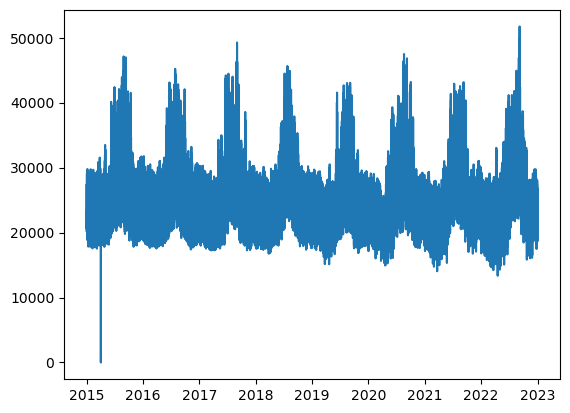

In [199]:
plt.plot(data['timestamp'], data['load_MW'])

In [202]:
df_2015 = data[data['timestamp'].dt.year == 2015]
df_2015[df_2015['load_MW'] < 10000]

,timestamp,freq,market,ba_name,load_MW,minutes,dayofweek
26361,2015-04-02 20:45:00,5m,RT5M,CAISO,8316.0,1245,3
26258,2015-04-02 23:05:00,5m,RT5M,CAISO,0.0,1385,3


In [203]:
df_2015 = data[data['timestamp'].dt.year == 2015]

In [204]:
df_2015[df_2015['load_MW'] < 10000]

,timestamp,freq,market,ba_name,load_MW,minutes,dayofweek
26361,2015-04-02 20:45:00,5m,RT5M,CAISO,8316.0,1245,3
26258,2015-04-02 23:05:00,5m,RT5M,CAISO,0.0,1385,3


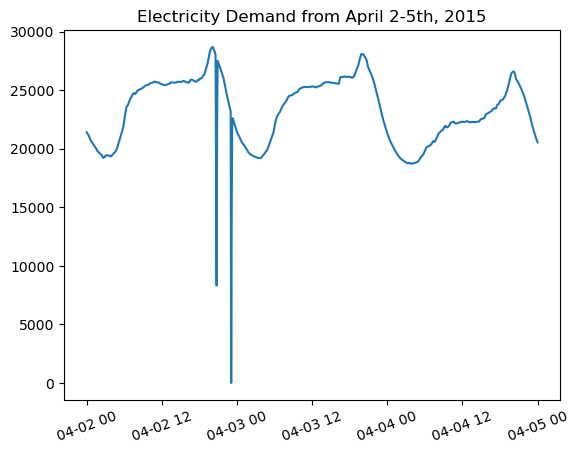

In [205]:
problem_range = df_2015[(df_2015['timestamp'] <= '2015-04-05') & (df_2015['timestamp'] >= '2015-04-02')].sort_values('timestamp', ascending=True)
plt.plot(problem_range['timestamp'], problem_range['load_MW'])
plt.title("Electricity Demand from April 2-5th, 2015")
plt.xticks(rotation=20);

In [206]:
data = data[~((data['timestamp'].dt.year == 2015) & (data['timestamp'].dt.month == 4) & (data['timestamp'].dt.day == 2))]
df_2015 = data[data['timestamp'].dt.year == 2015]

## Duck Curves over the Years

One of the first analyses we want to do is to understand how our duck curves are changing year-over-year.

### Line-plot

Let's first start by visualizing our time series data in one big line-plot.

Text(0.5, 1.0, 'Energy Demand')

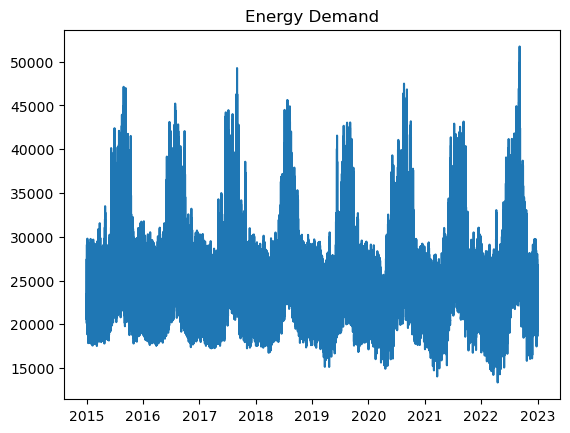

In [207]:
plt.plot(data['timestamp'], data['load_MW'])
plt.title("Energy Demand")

Hmm, on the face of it, the data looks surprisingly stationary! While we have some sharper peaks and lower lows in later years, the data stay fairly stable!

### Daily Duck Curves

Now, let's visualize our daily duck curves, and take a look at the average duck from year to year.

/var/folders/r2/k7ydhtv97nvfmfl71y382zy40000gn/T/ipykernel_96361/1118690249.py:3: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  df_2015['viz'] = df_2015['timestamp'].dt.time.astype(str).astype('datetime64[ns]')
/var/folders/r2/k7ydhtv97nvfmfl71y382zy40000gn/T/ipykernel_96361/1118690249.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_2015['viz'] = df_2015['timestamp'].dt.time.astype(str).astype('datetime64[ns]')
/var/folders/r2/k7ydhtv97nvfmfl71y382zy40000gn/T/ipykernel_96361/1118690249.py:22: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_

Text(0.5, 0, '')

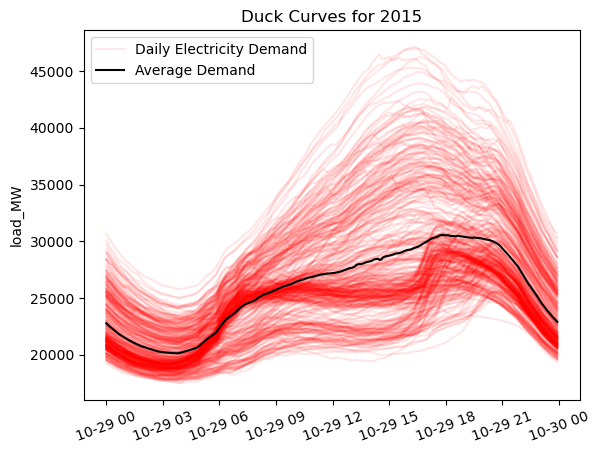

In [208]:
# Create new column of datetimes so axes between different plots are consistent (and so matplotlib can actually read these)
# Will return time-zone naive times, so for loop doesn't need to worry about them
df_2015['viz'] = df_2015['timestamp'].dt.time.astype(str).astype('datetime64[ns]') 
curr_day = np.datetime64("2015-01-01")
next_day = np.datetime64('2015-01-02')

# Overlays every day's duck curve on top of one another
labeled = 0
while next_day <= np.datetime64('2016-01-01'):
    if curr_day != '2015-04-03':
        curr_day_df = df_2015[(df_2015['timestamp'] < str(next_day)) & (df_2015['timestamp'] >= str(curr_day))]
        if not labeled:
            sns.lineplot(x='viz', y='load_MW', data=curr_day_df, c='r', alpha=0.1, label='Daily Electricity Demand')
            labeled += 1
        else:
            sns.lineplot(x='viz', y='load_MW', data=curr_day_df, c='r', alpha=0.1)
    curr_day += np.timedelta64(1, 'D')
    next_day += np.timedelta64(1, 'D')

# Compute average duck
avg_compute = df_2015
avg_compute['time'] = avg_compute['viz'].dt.time
avg_compute = avg_compute.groupby('time')['load_MW'].mean()
avg_compute = avg_compute.reset_index()
avg_compute['time'] = avg_compute['time'].astype(str).astype('datetime64[ns]')
sns.lineplot(x='time', y='load_MW', data=avg_compute, c='black', label='Average Demand')

plt.legend()
plt.xticks(rotation=20)
plt.title('Duck Curves for 2015')
plt.xlabel('')

To simplify our implementation, let's create a few functions to help us craft this EDA.

In [102]:
def plot_overlaid_ducks(data, year, ax=None):
    # Overlays every day's duck curve on top of one another
    data = data[data['timestamp'].dt.year == year]
    labeled = 0
    curr_day = np.datetime64(str(year) + "-01-01")
    next_day = np.datetime64(str(year) + '-01-02')
    while next_day <= np.datetime64(str(year + 1) + '-01-01'):
        if curr_day != '2015-04-03':
            curr_day_df = data[(data['timestamp'] < str(next_day)) & (data['timestamp'] >= str(curr_day))]
            if not labeled:
                sns.lineplot(x='minutes', y='load_MW', data=curr_day_df, c='r', alpha=0.1, label='Daily Electricity Demand', ax=ax)
                labeled += 1
            else:
                sns.lineplot(x='minutes', y='load_MW', data=curr_day_df, c='r', alpha=0.1, ax=ax)
        curr_day += np.timedelta64(1, 'D')
        next_day += np.timedelta64(1, 'D')
    
def plot_avg_duck(data, year, color, ax=None):
    # Compute average duck
    avg_compute = data[data['timestamp'].dt.year == year]
    avg_compute = avg_compute.groupby('minutes')['load_MW'].mean()
    avg_compute = avg_compute.reset_index()
    sns.lineplot(x='minutes', y='load_MW', data=avg_compute, c=color, label='Average Demand', ax=ax)

def plot_daily_duck_curves(data, year):
    color = 'black'
    plot_overlaid_ducks(data, year)
    plot_avg_duck(data, year, color)

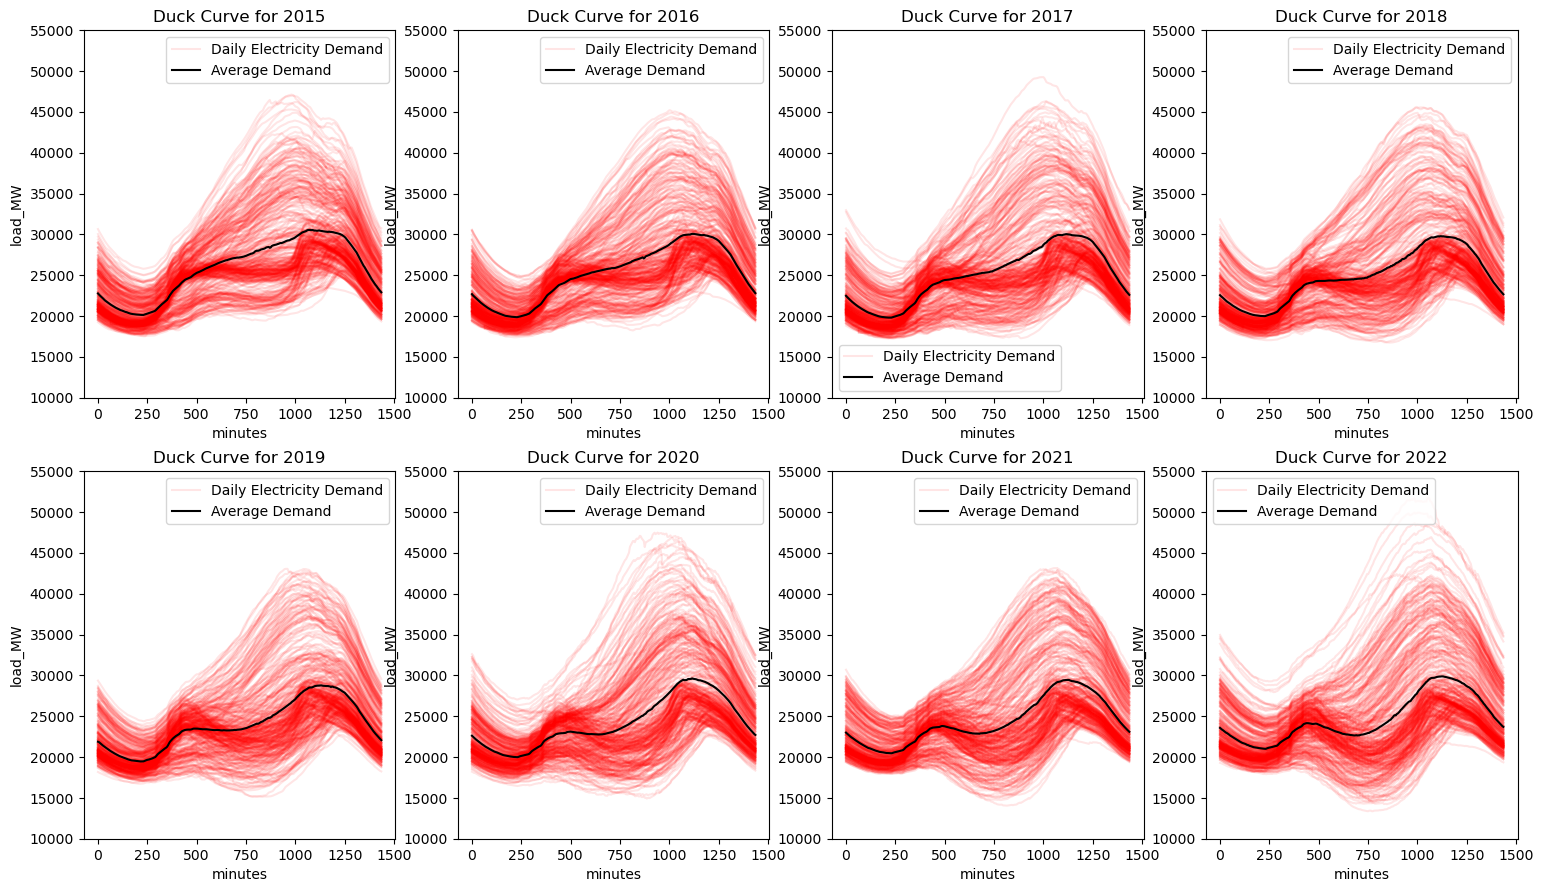

In [108]:
fig, axs = plt.subplots(2, 4)
fig.set_size_inches(18.5, 10.5)
years = np.arange(2015, 2023).reshape(2, 4)

i = 0
while i < 2:
    j = 0
    while j < 4:
        plot_overlaid_ducks(data, years[i][j], axs[i][j])
        plot_avg_duck(data, years[i][j], 'black', axs[i][j])
        axs[i][j].title.set_text("Duck Curve for " + str(years[i][j]))
        axs[i][j].set_ylim(10000, 55000)
        j += 1
    i += 1

Interestingly enough, it seems like from year to year, the duck curve is becoming much more pronounced: The hump at minute 500 is getting higher and higher, and the dip at 750 minutes is becoming more pronounced.

To get a better picture of how our duck curves changed over time, we can also take a look at 
1. Duck curves from every year, color coded by how much time transpired since 2015
2. How much the electricity load changes in a day, and whether that has increased or decreased over the years.

In [213]:
pd.DatetimeIndex(["2015-01-01"]).to_numpy()[0]

numpy.datetime64('2015-01-01T00:00:00.000000000')

In [214]:
data['days_transpired'] = (data['timestamp'] - pd.DatetimeIndex(["2015-01-01"]).to_numpy()[0]).dt.days

/var/folders/r2/k7ydhtv97nvfmfl71y382zy40000gn/T/ipykernel_96361/74990330.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['days_transpired'] = (data['timestamp'] - pd.DatetimeIndex(["2015-01-01"]).to_numpy()[0]).dt.days


### Color-coded by time transpired

These visualizations didn't work very well, since there is so much data. Overplotting made it very difficult to really be able to say anything meaningful here.

In [215]:
colors = sns.color_palette("crest", n_colors=max(data['days_transpired']))
len(colors)

2921

In [216]:
max(data['days_transpired'])

2921

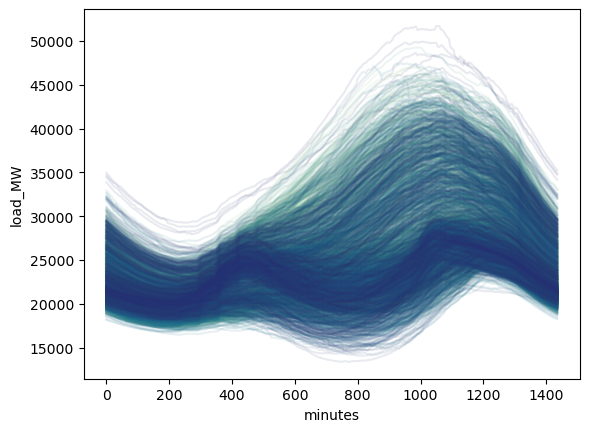

In [161]:
# Overlays every day's duck curve on top of one another
# This Visualization didn't work; there's just too much overplotting for this to be useful

"""colors = sns.color_palette("crest", n_colors=max(data['days_transpired']) + 1)
data = data.reset_index(drop=True)
labeled = 0
curr_day = np.datetime64("2015-01-01")
next_day = np.datetime64('2015-01-02')
i = 0
while next_day <= np.datetime64('2023-01-01'):
    if curr_day != np.datetime64('2015-04-02'):
        curr_day_df = data[(data['timestamp'] < str(next_day)) & (data['timestamp'] >= str(curr_day))]
        sns.lineplot(x='minutes', y='load_MW', data=curr_day_df, color=colors[i], alpha=0.1)
    curr_day += np.timedelta64(1, 'D')
    next_day += np.timedelta64(1, 'D')
    i += 1

plt.legend([], [], frameon=False)"""

### Visualizing Electricity Load Ranges
We also want to take a look at how much electricity demand fluctuates in a day. Let's visualize the range of electricity loads that are seen from day-to-day in our dataset.

Text(0.5, 0, 'Days since 2015-01-01')

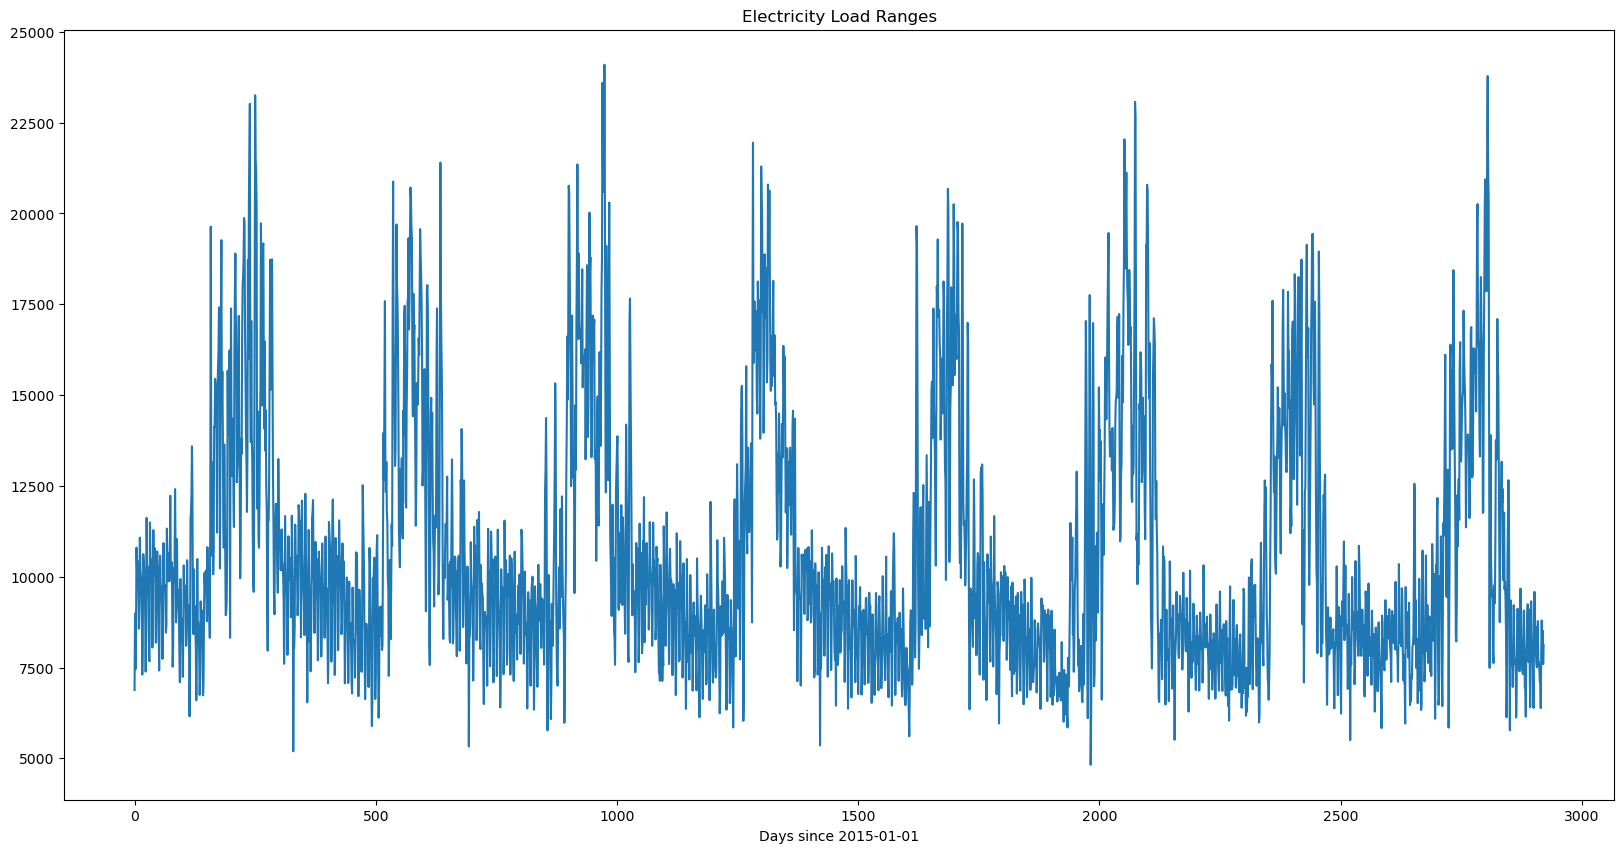

In [233]:
maxes = data.groupby('days_transpired')['load_MW'].max()
mins = data.groupby('days_transpired')['load_MW'].min()
plt.figure(figsize=(20, 10))
plt.plot(maxes.index, maxes - mins)
plt.title("Electricity Load Ranges")
plt.xlabel("Days since 2015-01-01")

Interesting: it seems like certain seasons see a massive spike in the range between their lowest and highest points of demand. Let's examine this pattern in greater detail.

## Seasonal Changes

For consistency, we'll adhere to [meteorological definitions of seasons](https://www.timeanddate.com/calendar/aboutseasons.html#:~:text=In%20the%20Northern%20Hemisphere%2C%20for,1%20to%20November%2030%3B%20and). We'll start with some feature engineering.

In [220]:
data['is_fall'] = (data['timestamp'].dt.month >= 9) & (data['timestamp'].dt.month <= 11)
data['is_winter'] = (data['timestamp'].dt.month == 12) | (data['timestamp'].dt.month <= 2)
data['is_spring'] = (data['timestamp'].dt.month >= 3) & (data['timestamp'].dt.month <= 5)
data['is_summer'] = (data['timestamp'].dt.month >= 6) & (data['timestamp'].dt.month <= 8)

/var/folders/r2/k7ydhtv97nvfmfl71y382zy40000gn/T/ipykernel_96361/3673667735.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['is_fall'] = (data['timestamp'].dt.month >= 9) & (data['timestamp'].dt.month <= 11)
/var/folders/r2/k7ydhtv97nvfmfl71y382zy40000gn/T/ipykernel_96361/3673667735.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['is_winter'] = (data['timestamp'].dt.month == 12) | (data['timestamp'].dt.month <= 2)
/var/folders/r2/k7ydhtv97nvfmfl71y382zy40000gn/T/ipykernel_96361/3673667735.

In [225]:
data['days_transpired'].unique()

array([   0,    1,    2, ..., 2919, 2920, 2921])

In [234]:
def plot_seasonal_ducks(data, season, ax=None):
    # Overlays every day's duck curve on top of one another
    data = data[data['is_' + season]]
    labeled = 0
    for day in data['days_transpired'].unique():
        curr_day_df = data[data['days_transpired'] == day]
        if not labeled:
            sns.lineplot(x='minutes', y='load_MW', data=curr_day_df, c='teal', alpha=0.1, label='Daily Electricity Demand', ax=ax)
            labeled += 1
        else:
            sns.lineplot(x='minutes', y='load_MW', data=curr_day_df, c='teal', alpha=0.1, ax=ax)

def plot_szn_avg_duck(data, season, color, ax=None):
    # Compute average duck
    avg_compute = data[data['is_' + season]]
    avg_compute = avg_compute.groupby('minutes')['load_MW'].mean()
    avg_compute = avg_compute.reset_index()
    sns.lineplot(x='minutes', y='load_MW', data=avg_compute, c=color, label='Average Demand', ax=ax)

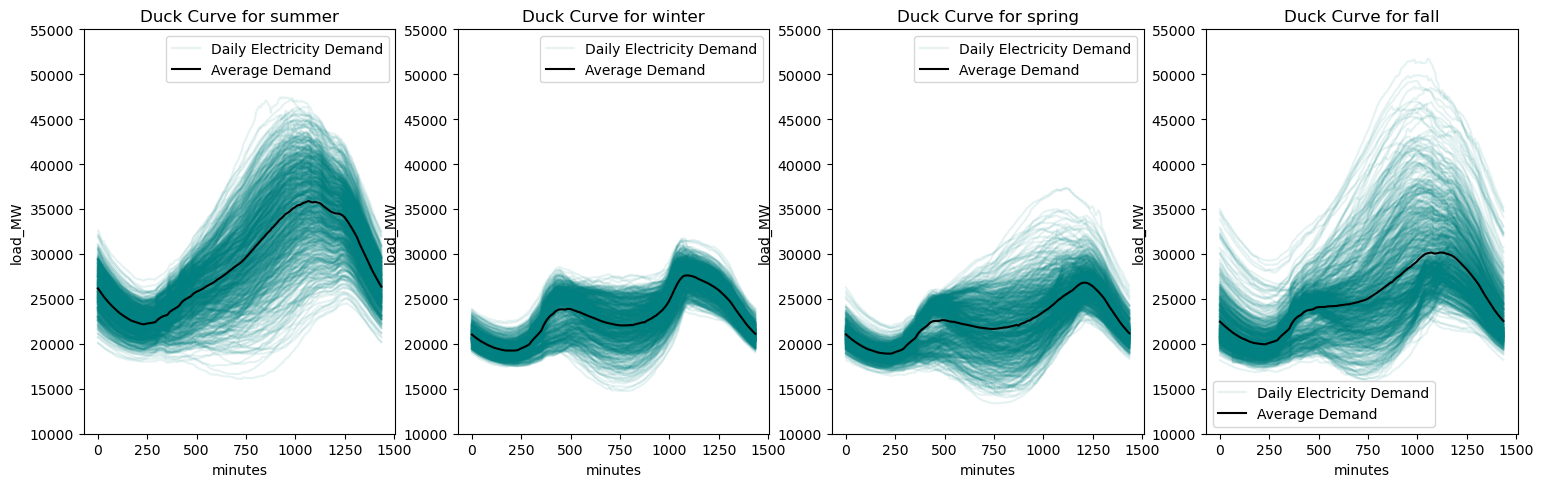

In [235]:
fig, axs = plt.subplots(1, 4)
fig.set_size_inches(18.5, 5.25)
szns = ['summer', 'winter', 'spring', 'fall']

i = 0
while i < 4:
    plot_seasonal_ducks(data, szns[i], axs[i])
    plot_szn_avg_duck(data, szns[i], 'black', axs[i])
    axs[i].title.set_text("Duck Curve for " + str(szns[i]))
    axs[i].set_ylim(10000, 55000)
    i += 1

## Days of the Week

In [239]:
def plot_dow_ducks(data, dayofweek=0, ax=None):
    # Overlays every day's duck curve on top of one another
    data = data[data['dayofweek'] == dayofweek]
    labeled = 0
    for day in data['days_transpired'].unique():
        curr_day_df = data[data['days_transpired'] == day]
        if not labeled:
            sns.lineplot(x='minutes', y='load_MW', data=curr_day_df, c='goldenrod', alpha=0.1, label='Daily Electricity Demand', ax=ax)
            labeled += 1
        else:
            sns.lineplot(x='minutes', y='load_MW', data=curr_day_df, c='goldenrod', alpha=0.1, ax=ax)

def plot_dow_avg_duck(data, dayofweek=0, color='black', ax=None):
    # Compute average duck
    avg_compute = data[data['dayofweek'] == dayofweek]
    avg_compute = avg_compute.groupby('minutes')['load_MW'].mean()
    avg_compute = avg_compute.reset_index()
    sns.lineplot(x='minutes', y='load_MW', data=avg_compute, c=color, label='Average Demand', ax=ax)

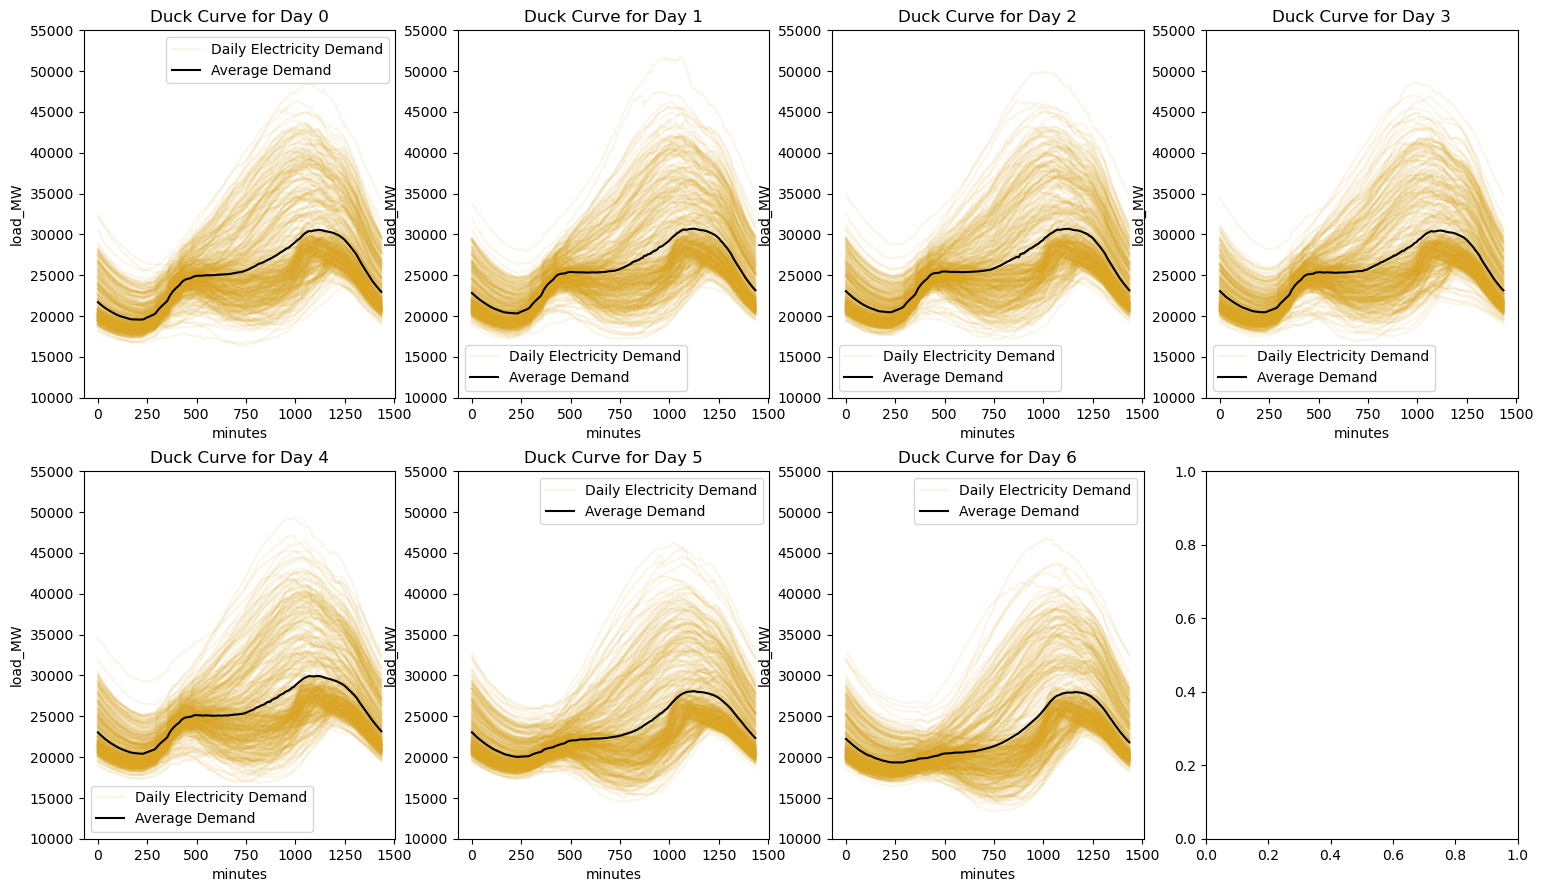

In [240]:
fig, axs = plt.subplots(2, 4)
fig.set_size_inches(18.5, 10.5)
dows = [[0, 1, 2, 3],
         [4, 5, 6]]

i = 0
while i < 2:
    j = 0
    while j < 4:
        if i == 1 and j == 3:
            break
        else:
            plot_dow_ducks(data, dows[i][j], axs[i][j])
            plot_dow_avg_duck(data, dows[i][j], 'black', axs[i][j])
            axs[i][j].title.set_text("Duck Curve for Day " + str(dows[i][j]))
            axs[i][j].set_ylim(10000, 55000)
        j += 1
    i += 1